In [1]:
from functions import *
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pathlib import Path



In [2]:
processRaw = True #  whether to process pupil and gaze from the uncleaned file
saveFiles = False


In [3]:
#read in the mega df
local_username = 'yud070'
pathEL = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_tracker/"
pathpy = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_psychopy/"

readIn = sorted([f for f in os.listdir(pathpy)])[-48:-2]


relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']
selectEye = 'AVERAGE_PUPIL_SIZE'
included = 8000


# Load

In [4]:

# Define paths
BASE_PATH = Path("Z:/yueying/psychedeLights_YueyingDong")
PSYCHOPY_PATH = BASE_PATH / "results/data/psychopy"
PUPIL_RAW_PATH = BASE_PATH / "pupRaw_formatted"
PUPIL_CLEAN_PATH = BASE_PATH / "results/data/pupClean"

GAZE_RAW_PATH = BASE_PATH/ "gazeRaw_formatted"

# Load behavioral data
print("Loading behavioral data...")
psy_files = glob.glob(str(PSYCHOPY_PATH / "psyFull_*.csv"))
psyFull = pd.concat(
    [pd.read_csv(f) for f in psy_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(psyFull)} trials from {len(psy_files)} files")

if processRaw:

    # ===== Process pupil data =====
    print("\nLoading raw pupil data for processing...")
    pupil_raw_files = glob.glob(str(PUPIL_RAW_PATH / "*.csv"))
    pupFullTrial_raw = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_raw_files],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(pupFullTrial_raw)} trials from {len(pupil_raw_files)} files")
    
    print("\nProcessing pupil data...")
    pupClean, combined_participant_mask = process_pupil_data_pipeline(pupFullTrial_raw, psyFull,
                                           max_missing_proportion = 0.1)
    
    # ===== Process gaze data ===== 
    print("\nLoading raw gaze data for processing...")
    gaze_raw_files_x = glob.glob(str(GAZE_RAW_PATH / "*x*.csv"))
    gaze_raw_files_y = glob.glob(str(GAZE_RAW_PATH / "*y*.csv"))

    # Sanity check: make sure x and y files match
    if len(gaze_raw_files_x) != len(gaze_raw_files_y):
        print(f"  WARNING: Found {len(gaze_raw_files_x)} x-files but {len(gaze_raw_files_y)} y-files!")

    gazeFullTrial_x_raw = pd.concat(
        [pd.read_csv(f).iloc[:,1:] for f in gaze_raw_files_x],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(gazeFullTrial_x_raw)} trials (x-axis) from {len(gaze_raw_files_x)} files")

    gazeFullTrial_y_raw = pd.concat(
        [pd.read_csv(f).iloc[:,1:] for f in gaze_raw_files_y],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(gazeFullTrial_y_raw)} trials (y-axis) from {len(gaze_raw_files_y)} files")
    
    print("\nProcessing gaze data...")
    gaze_clean = process_gaze_data_pipeline(
        pupil_raw_df = pupFullTrial_raw,
        gaze_x_raw_df = gazeFullTrial_x_raw,
        gaze_y_raw_df = gazeFullTrial_y_raw,
        pupil_clean_df = pupClean,
        pupil_std_mask_df = combined_participant_mask,
    )

    # Extract x and y gaze data
    gaze_x = gaze_clean.loc['x']
    shift_df = calculate_gaze_shifts(gaze_clean)
    
    print(f"\n✓ Processing complete!")
    print(f"  Final pupil data: {len(pupClean)} trials")
    print(f"  Final gaze data: {len(gaze_x)} trials (x and y)")
    
else:
    print("\nLoading pre-processed pupil data...")
    pupil_clean_files = glob.glob(str(PUPIL_CLEAN_PATH / "*.csv"))
    pupClean = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_clean_files],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(pupClean)} trials from {len(pupil_clean_files)} files")

print("\n✓ Data loading complete!")

Loading behavioral data...
  Loaded 9924 trials from 3 files

Loading raw pupil data for processing...
  Loaded 9924 trials from 3 files

Processing pupil data...
PUPIL DATA PROCESSING PIPELINE
Stage 1: Initial cleaning...
Stage 2: Smoothing...


c:\Users\yud070.AD\Desktop\yd_pupil_2026\yd2026_paper\functions\processPup.py:103: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  smoothed = cleaned_once.rolling(


Stage 3: Second cleaning...
Applying participant-level filtering (threshold=6 MAD)...

Filtering trials by data quality...
  Trials with <10% missing data: 9061/9924
  Trials with valid responses: 8920/9061

PROCESSING COMPLETE
Total trials retained: 8920

Trials per participant:
260    216
251    215
252    215
281    215
290    214
294    213
287    213
286    213
259    213
280    213
255    212
282    212
249    211
275    211
291    211
296    211
283    210
279    210
257    209
293    208
289    208
264    208
261    208
266    207
295    207
276    205
268    204
278    201
274    200
269    194
265    193
262    190
272    190
253    187
273    183
258    181
256    181
267    181
270    180
284    172
263    171
271    170
292    167
288    141
254     82
250     64
Name: count, dtype: int64

Loading raw gaze data for processing...
  Loaded 9867 trials (x-axis) from 2 files
  Loaded 9867 trials (y-axis) from 2 files

Processing gaze data...
GAZE DATA PROCESSING

Step 1: Gener

c:\Users\yud070.AD\Desktop\yd_pupil_2026\yd2026_paper\functions\processGaze.py:180: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  gaze_smoothed = gaze_filtered.iloc[:, 1:].rolling(


Step 8: Interpolating missing segments (method=nearest)...

GAZE PROCESSING COMPLETE
Final dataset: 8920 trials × 8000 timepoints
GAZE SHIFT CALCULATION

Step 1: Smoothing gaze data (window=51)...
  Smoothed 8920 trials
Step 2: Detecting gaze shifts (threshold=6px)...
Step 3: Filtering shifts (X≥8px or Y≥8px)...
  Detected 164,960 X-shifts and 164,956 Y-shifts
Step 4: Formatting output...

GAZE SHIFT CALCULATION COMPLETE
Output shape: (17840, 8002)
Trials with shifts: 8919

✓ Processing complete!
  Final pupil data: 8920 trials
  Final gaze data: 8920 trials (x and y)

✓ Data loading complete!


In [5]:
shiftDf = shift_df[shift_df.axis == 'x'].iloc[:,1:].merge(psyFull[['TRIALID','cuedItem']])
shiftDf = shiftDf.set_index('cuedItem')

toward = shiftDf.copy()
away = shiftDf.copy()

leftAll = toward.loc['left'].iloc[:,2:].values
toward.loc['left',toward.columns[2:]] = np.where(leftAll < 0,1,0)
rightAll = toward.loc['right'].iloc[:,2:].values
toward.loc['right',toward.columns[2:]] = np.where(rightAll > 0,1,0)

leftAll = away.loc['left'].iloc[:,2:].values
away.loc['left',away.columns[2:]] = np.where(leftAll > 0,1,0)
rightAll = away.loc['right'].iloc[:,2:].values
away.loc['right', away.columns[2:]] = np.where(rightAll <0,1,0)

#get frequency
winsize = 100
freq = 1000
towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize

towardFreq.insert(0,'TRIALID',toward.TRIALID)
awayFreq.insert(0,'TRIALID',away.TRIALID)
towardFreq['towardness'] = 'toward'
awayFreq['towardness'] = 'away'
towardnessDf = pd.concat([towardFreq,awayFreq],axis = 0)
towardnessDf = towardnessDf.reset_index()
towardnessDf = towardnessDf.merge(psyFull[['trlType','TRIALID']])

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_15344\420590107.py:20: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_15344\420590107.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize


In [6]:
qq = towardnessDf.groupby(['towardness','trlType']).mean(numeric_only=True)
qqSd = towardnessDf.groupby(['towardness','trlType']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

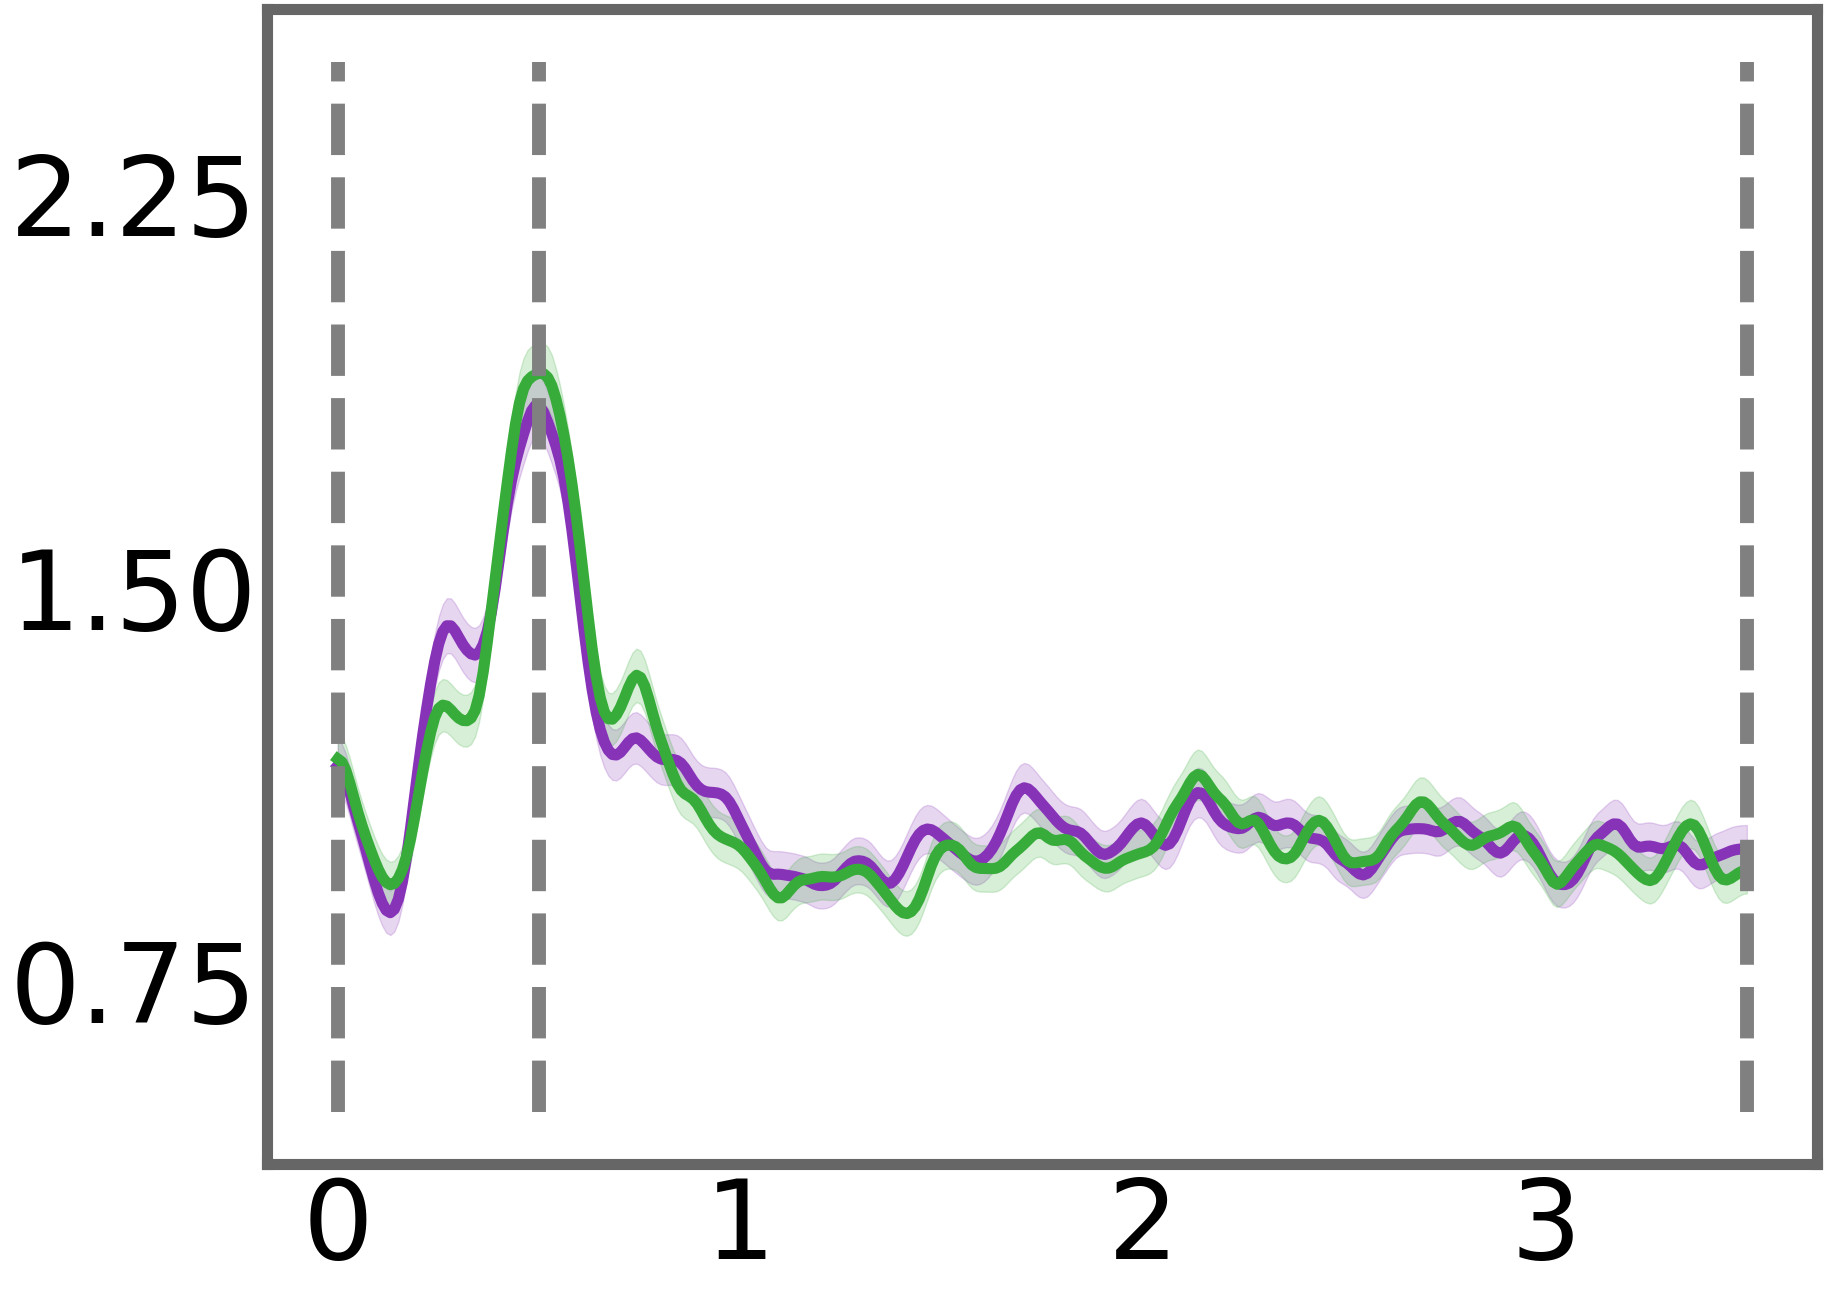

In [7]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth_signal(qq.iloc[i,4001:7501:10],11),c = ["#8733b8","#38ac3a",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth_signal(saccUpper.iloc[i,4001:7501:10]),
                       smooth_signal(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#8733b8","#38ac3a",][i%2]) for i in [2,3]]



plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

In [8]:

towardnessDf_bri = towardnessDf.merge(psyFull[['TRIALID','cuedItemBri','participant']],how = 'left')


KeyError: "['cuedItemBri'] not in index"

In [ ]:
qq = towardnessDf_bri.groupby(['towardness','cuedItemBri']).mean(numeric_only=True)
qqSd = towardnessDf_bri.groupby(['towardness','cuedItemBri']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

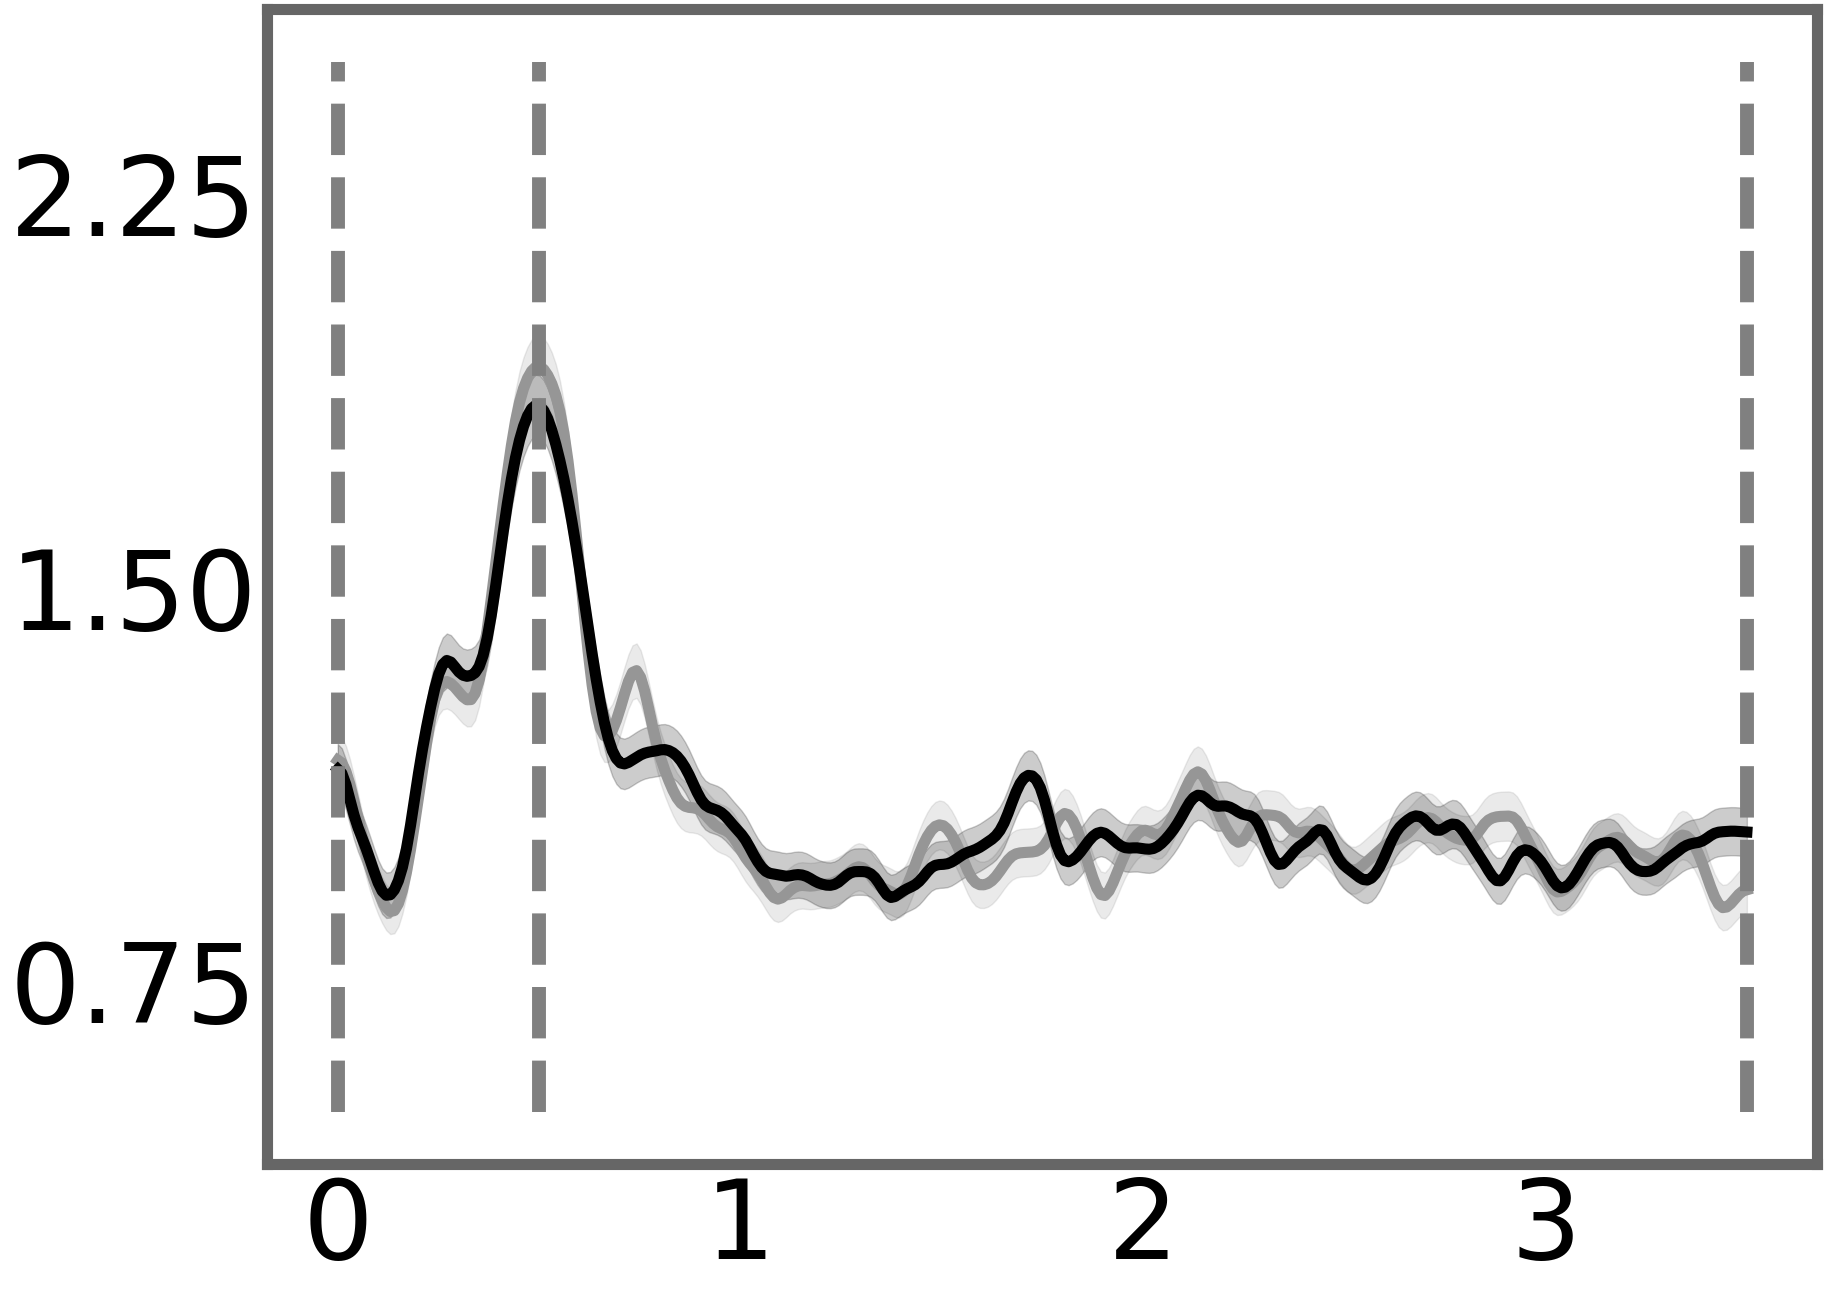

In [ ]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth_signal(qq.iloc[i,4001:7501:10],11),c = ["#969696","#000000",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth_signal(saccUpper.iloc[i,4001:7501:10]),
                       smooth_signal(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#969696","#000000",][i%2]) for i in [2,3]]



plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

In [18]:
gazeTemp = gaze_clean.reset_index().merge(psyFull[['TRIALID','cuedItem',]]).set_index(['cuedItem','axis'])

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_15344\1368209146.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_15344\1368209146.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520


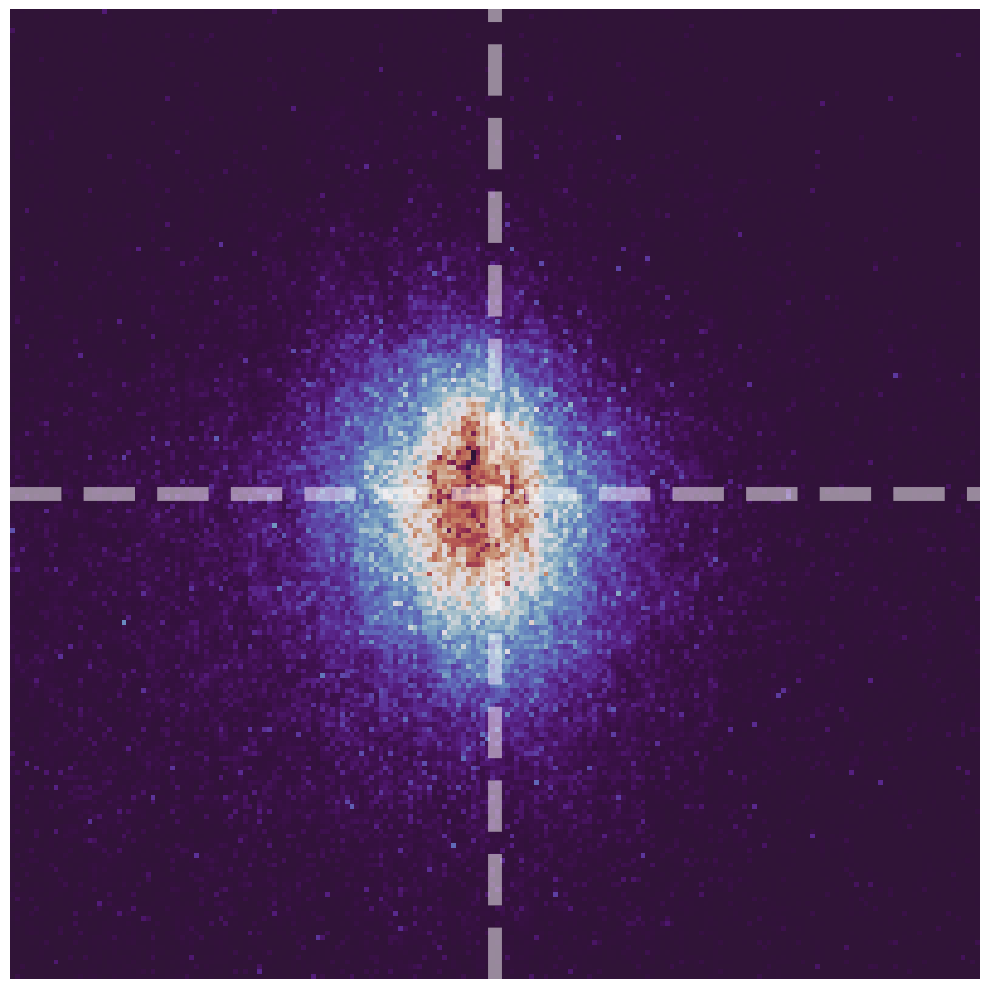

In [19]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
leftVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)

#plt.title('gaze position during retrocue & delay',size = 15)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_15344\1506284811.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_15344\1506284811.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520


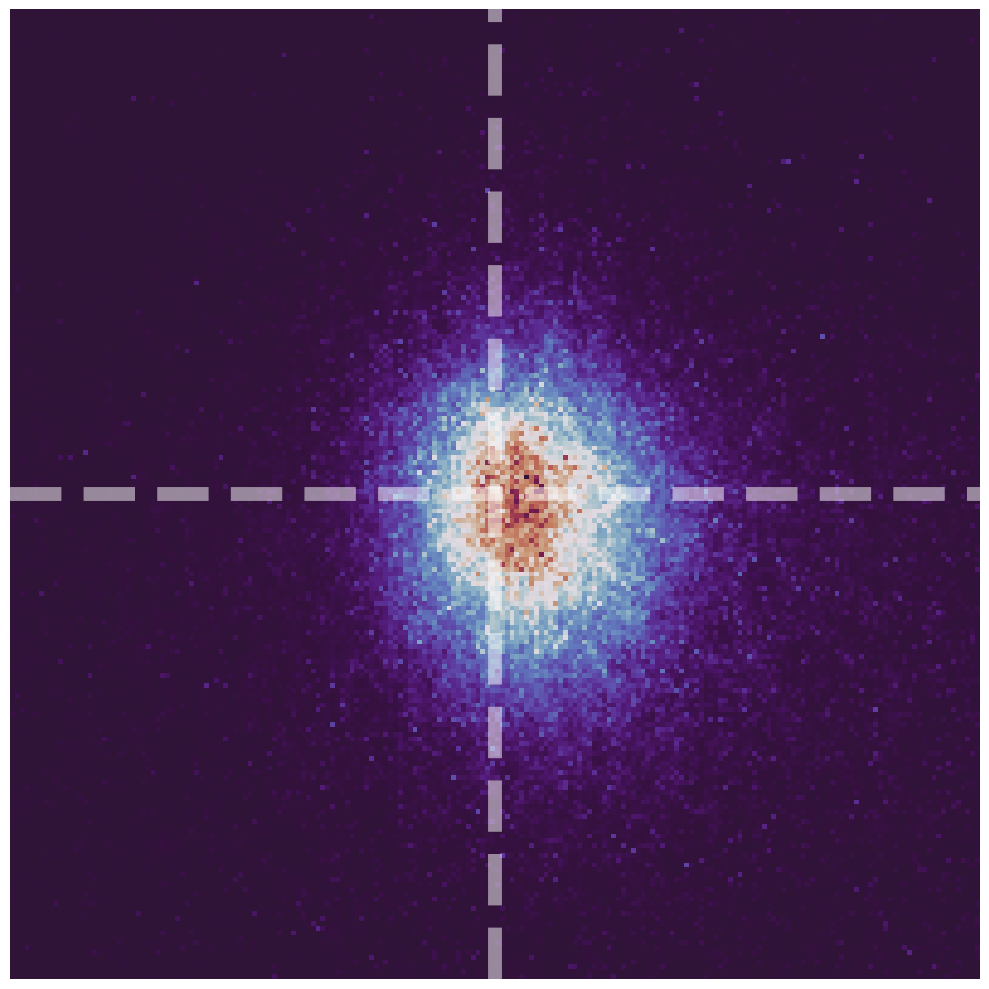

In [20]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
rightVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)

#plt.title('gaze position during retrocue & delay',size = 15)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


(-0.5, 210.025, 210.025, -0.5)

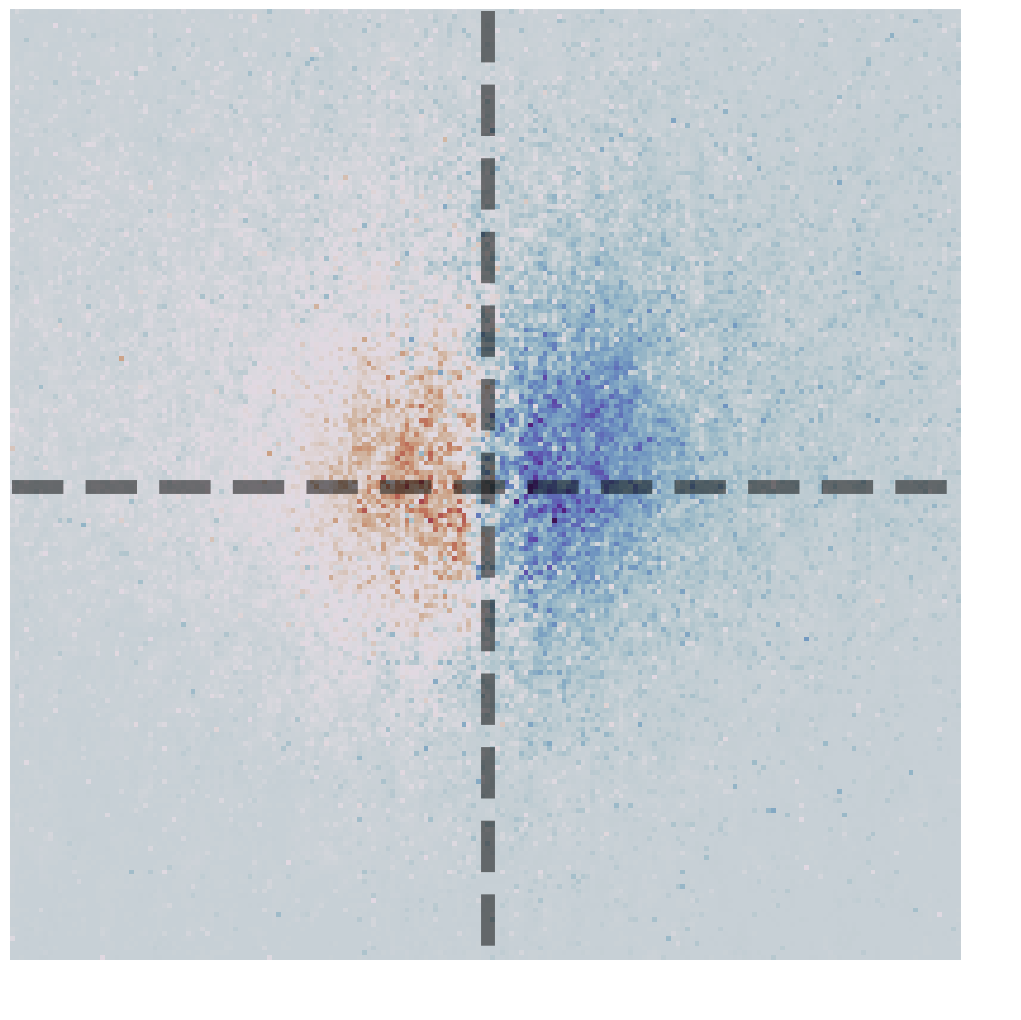

In [21]:
fs(13,13)

plt.imshow((leftVal - rightVal).T,cmap='twilight_shifted',vmin = -0.00032,vmax = 0.0004)
plt.vlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)
plt.hlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)

plt.axis('off')


# Handle Psychopy data

In [16]:
# Exclude participants
rejSubj = [254, 250]
psyFull = psyFull[~psyFull['participant'].isin(rejSubj)].reset_index(drop=True)
print(f"Excluded {len(rejSubj)} participants. Remaining trials: {len(psyFull)}")

# Add cued item brightness (left or right based on cued direction)
psyFull['cuedItemBri'] = psyFull.apply(
    lambda row: row['leftBri'] if row['cuedItem'] == 'left' else row['rightBri'],
    axis=1
)

# Calculate correctness (assuming 'rsp' should equal 'cuedItem' for correct trials)
psyFull['correctness'] = np.where(psyFull.rsp !='cuedItem',0,1)

# Log-transform reaction time
psyFull['logRT'] = np.log(psyFull['rt'])

# Map distractor type based on trial type and congruency
# Logic: incongruent trials flip the modality
distractor_mapping = {
    ('congruent', 'verbal'): 'verbal',
    ('incongruent', 'verbal'): 'visual',
    ('congruent', 'visual'): 'visual',
    ('incongruent', 'visual'): 'verbal'
}

psyFull['distractorType_visVer'] = psyFull.apply(
    lambda row: distractor_mapping.get(
        (row['distractorType'], row['trlType']),
        'noDistractor'
    ),
    axis=1
)

Excluded 2 participants. Remaining trials: 9492


In [17]:
psyFull.participant.value_counts()

participant
249.0    216
284.0    216
275.0    216
276.0    216
278.0    216
279.0    216
280.0    216
281.0    216
282.0    216
283.0    216
286.0    216
251.0    216
287.0    216
289.0    216
290.0    216
291.0    216
292.0    216
293.0    216
294.0    216
295.0    216
274.0    216
273.0    216
272.0    216
271.0    216
252.0    216
253.0    216
255.0    216
256.0    216
257.0    216
258.0    216
259.0    216
260.0    216
261.0    216
262.0    216
263.0    216
264.0    216
265.0    216
266.0    216
267.0    216
268.0    216
269.0    216
270.0    216
296.0    216
288.0    204
Name: count, dtype: int64

# example trial, post cleaning

In [ ]:
events = {'fixation':0,'stim':500,'precueRest':3000,'retrocue':500,'delay':500,}

In [ ]:
fs(10, 5)
fig, ax = plt.subplots()

eg = 30  # np.random.randint(pupClean.shape[0])
trial_data = pupClean.iloc[eg, 1:].values
timepoints = np.arange(len(trial_data))

# Plot pupil trace
plt.plot(timepoints, trial_data, color='#1f77b4', linewidth=3)

# Event markers
event_times = np.cumsum(list(events.values()))
y_min, y_max = np.nanmin(trial_data), np.nanmax(trial_data)
plt.vlines(event_times, y_min, y_max, 
          linestyles='dashed', colors='grey', linewidth=5)

# Optional: Add event labels
event_names = list(events.keys())
for i, (time, name) in enumerate(zip(event_times, event_names)):
    plt.text(time, y_max * 1.01, name, 
            fontsize=20, ha='center', rotation=30)

# Styling
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Pupil Size', fontsize=20)

ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))

for spine in ax.spines.values():
    spine.set_color('#666666')
    spine.set_linewidth(5)



# Pupil results

In [ ]:
cList = ['#ba88e9','#5c1486','#60d062','#1e681f']

In [ ]:
pupNorm = pupClean.iloc[:,4001:7501].sub(np.nanmean(pupClean.iloc[:,3801:4001],axis =1,)[:,None],axis = 0)
pupNorm.insert(0,'TRIALID',pupClean.TRIALID)

pupNorm = pupNorm[~(pupNorm.iloc[:,1:3501].isnull().sum(axis =1) > 350)]
pupNorm = pupNorm.merge(psyFull[['participant','trlType','TRIALID','cuedItemBri',]],how = 'inner')
pupNorm = pupNorm[~pupNorm.participant.isin(rejSubj)]

pupNorm.shape[0]/(pupNorm.participant.nunique()*216)

## permutation test

In [ ]:
lenData = 3500
x = np.linspace(0,3.5,lenData)

In [ ]:
dataN = 35

a = pupNorm.iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[['trlType','cuedItemBri']]],axis = 1)
dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)


### Agg

In [ ]:
dsPup = pd.concat([a,pupNorm[['cuedItemBri']]],axis = 1)

In [ ]:
result = cluster_permutation_test(
    data_df=dsPup,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

In [ ]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in result['observed_clusters']]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

In [ ]:
pupMean = pupNorm.groupby(['cuedItemBri']).mean(numeric_only=True)
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

In [ ]:
fs(20,15)
fig,ax = plt.subplots()

[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),color = ['silver','black'][i],linewidth = 8) for i in range (2)]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),color =  ['silver','black'][i],alpha = 0.2)for i in range (2)]
plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
[plt.fill_between(i,160,180,color = "#949494",alpha = 0.2) for i in cluster_t]

plt.yticks(fontsize=60)
plt.xticks(fontsize=60)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


### semantic

In [ ]:
pupMean = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

In [ ]:
dsPup_verbal

In [ ]:
result_visual = cluster_permutation_test(
    data_df=dsPup_verbal,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

### visual

In [ ]:
result_visual = cluster_permutation_test(
    data_df=dsPup_visual,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

In [ ]:
cluster_pvalues = [
    np.mean(cluster_stat > result_visual['null_distribution'])
    for cluster_stat in [result_visual['observed_stats'][cluster].sum() 
                         for cluster in result_visual['observed_clusters']]
]

cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in result_visual['observed_clusters']]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

In [ ]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]
[plt.fill_between(i,160,180,color = "#359937",alpha = 0.2) for i in cluster_t]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)